<a href="https://colab.research.google.com/github/emraankazmi5-coder/deeplearning/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Set up data**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# Load MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# For CNN
x_train_cnn = x_train[..., None]     # (N, 28, 28, 1)
x_test_cnn  = x_test[..., None]

# For FCN
x_train_fcn = x_train.reshape(-1, 28*28)   # (N, 784)
x_test_fcn  = x_test.reshape(-1, 28*28)

num_classes = 10

# training-set sizes (10% steps)
train_sizes = [6000 * i for i in range(1, 11)]
train_sizes


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[6000, 12000, 18000, 24000, 30000, 36000, 42000, 48000, 54000, 60000]

2. **Define FCN and CNN models**

In [ ]:
def build_fcn():
    model = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


def build_cnn():
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


3. **Train both models at different training sizes and record test accuracy**

In [ ]:
EPOCHS = 5
BATCH = 128

results = []

for n in train_sizes:
    print(f"\n=== Training size: {n} ===")
    idx = np.random.choice(len(x_train), size=n, replace=False)

    # FCN
    fcn = build_fcn()
    fcn.fit(
        x_train_fcn[idx], y_train[idx],
        epochs=EPOCHS,
        batch_size=BATCH,
        verbose=0,
        validation_split=0.1
    )
    fcn_test_loss, fcn_test_acc = fcn.evaluate(x_test_fcn, y_test, verbose=0)

    # CNN
    cnn = build_cnn()
    cnn.fit(
        x_train_cnn[idx], y_train[idx],
        epochs=EPOCHS,
        batch_size=BATCH,
        verbose=0,
        validation_split=0.1
    )
    cnn_test_loss, cnn_test_acc = cnn.evaluate(x_test_cnn, y_test, verbose=0)

    results.append({
        "train_size": n,
        "fcn_test_acc": float(fcn_test_acc),
        "cnn_test_acc": float(cnn_test_acc),
        "fcn_test_loss": float(fcn_test_loss),
        "cnn_test_loss": float(cnn_test_loss),
    })

df = pd.DataFrame(results)
df



=== Training size: 6000 ===

=== Training size: 12000 ===

=== Training size: 18000 ===

=== Training size: 24000 ===

=== Training size: 30000 ===

=== Training size: 36000 ===

=== Training size: 42000 ===

=== Training size: 48000 ===

=== Training size: 54000 ===

=== Training size: 60000 ===


,train_size,fcn_test_acc,cnn_test_acc,fcn_test_loss,cnn_test_loss
0,6000,0.9322,0.9685,0.219725,0.102779
1,12000,0.9526,0.9829,0.155783,0.055265
2,18000,0.9585,0.9829,0.131698,0.050307
3,24000,0.9636,0.9850,0.108293,0.043970
4,30000,0.9697,0.9871,0.099766,0.038755
5,36000,0.9718,0.9897,0.095270,0.032535
6,42000,0.9725,0.9883,0.086412,0.034436
7,48000,0.9759,0.9890,0.076416,0.033282
8,54000,0.9768,0.9910,0.070996,0.029145
9,60000,0.9779,0.9895,0.073674,0.029272


4. **Plot accuracy vs training size (“show with data”)**

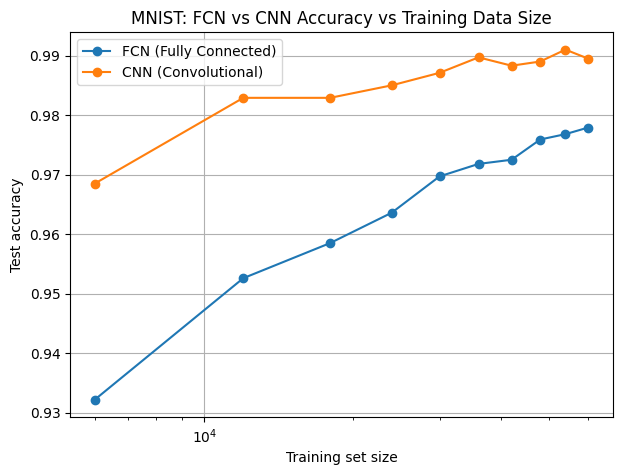

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(df["train_size"], df["fcn_test_acc"], marker="o", label="FCN (Fully Connected)")
plt.plot(df["train_size"], df["cnn_test_acc"], marker="o", label="CNN (Convolutional)")
plt.xscale("log")
plt.xlabel("Training set size")
plt.ylabel("Test accuracy")
plt.title("MNIST: FCN vs CNN Accuracy vs Training Data Size")
plt.legend()
plt.grid(True)
plt.show()


5. **Decide which model plateaus first (simple rule)**

In [ ]:
def first_plateau_point(sizes, accs, eps=0.002, consecutive=2):
    sizes = list(sizes)
    accs = list(accs)
    gains = [accs[i+1] - accs[i] for i in range(len(accs)-1)]
    for i in range(len(gains) - (consecutive - 1)):
        if all(g < eps for g in gains[i:i+consecutive]):
            return sizes[i], gains
    return None, gains

fcn_plateau, fcn_gains = first_plateau_point(df["train_size"], df["fcn_test_acc"])
cnn_plateau, cnn_gains = first_plateau_point(df["train_size"], df["cnn_test_acc"])

print("FCN gains:", [round(g, 5) for g in fcn_gains])
print("CNN gains:", [round(g, 5) for g in cnn_gains])
print("FCN plateau at:", fcn_plateau)
print("CNN plateau at:", cnn_plateau)


FCN gains: [0.0204, 0.0059, 0.0051, 0.0061, 0.0021, 0.0007, 0.0034, 0.0009, 0.0011]
CNN gains: [0.0144, 0.0, 0.0021, 0.0021, 0.0026, -0.0014, 0.0007, 0.002, -0.0015]
FCN plateau at: 48000
CNN plateau at: 36000


6. **Conclusion**

For small training sizes (60000 images), the CNN already reaches about 0.97 test accuracy, while the FCN is around 0.93. As we increase the training set to 60000 images, the CNN peaks near 0.99 test accuracy and the FCN around 0.978.

The convolutional model (CNN) learns to recognize digits faster and reaches better accuracy than the fully connected model (FCN).
The CNN stops improving (plateaus) earlier, because it has already learned almost everything it can from the data.
The FCN needs more data to get close, and even then its best accuracy is still a little worse than the CNN’s.

